In [1]:
##Load packages

import pandas as pd
import numpy as np
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt



In [30]:
#Load pre-processed datasets

tomtom = pd.read_parquet("tomtom_data.parquet")
vessels = pd.read_parquet("vessels_data.parquet")
weather = pd.read_csv("SAIL_Amsterdam_10min_Weather_2025-08-20_to_2025-08-24.csv")
sensors_location = pd.read_csv("sensor-location.xlsx - Sheet1.csv", ).rename(columns={"Objectnummer": "sensor_id"})
sensors = pd.read_csv("sensordata_SAIL2025.csv", parse_dates=["timestamp"])


In [32]:
#Mutations sensor information

#Replace , by r . so it can be used in calculations
sensors_location["Effectieve breedte"] = (
    sensors_location["Effectieve breedte"]
    .astype(str)
    .str.replace(",", ".")
    .astype(float)
)

# Retrieve latitude and longitude information in separate columns
sensors_location[["lat", "lon"]] = (
    sensors_location["Lat/Long"]
    .str.replace(" ", "")  
    .str.split(",", expand=True)
    .astype(float)
)

#Divide all counts by the effective width of the sensor location
width = sensors_location.set_index("sensor_id")["Effectieve breedte"].to_dict()

for col in sensors.columns:
    if "_" in col:  
        sensor_id = col.split("_")[0]
        if sensor_id in width:
            sensors[col] = sensors[col] / (width[sensor_id])



In [33]:
## Mutations weather data

# replace 24 by 00 to account for UTC datetime
weather["DateTime"] = weather["DateTime"].str.replace(" 24:", " 00:", regex=False)

# Convert to UTC datetime and round up for every 3 minutes
weather["DateTime"] = pd.to_datetime(weather["DateTime"], format="%Y%m%d %H:%M")
weather = weather.set_index("DateTime")
weather_3min = weather.resample("3min").nearest()
weather_3min = weather_3min.reset_index()

In [34]:
## Mutations vessel data

# Convert to UTC datetime and round up for every 3 minutes
vessels["timestamp"] = pd.to_datetime(vessels["timestamp"], utc=True, errors="coerce")
vessels["timestamp"] = vessels["timestamp"].dt.floor("3min")

#Take average longitude and latitude over 3 minutes and srot by datetime
vessels = (
    vessels.groupby(["timestamp", "imo-number"], as_index=False)
    .agg({
        "lat": "mean",
        "lon": "mean",
        "length": "first"
    })
)


In [35]:
##Combining vessel, weather and sensor data

#Ensure compatitibility datetime dataset
vessels["timestamp"] = pd.to_datetime(vessels["timestamp"], utc=True)
sensors["timestamp"] = pd.to_datetime(sensors["timestamp"], utc=True)
weather_3min["DateTime"] = pd.to_datetime(weather_3min["DateTime"], utc=True) 

#Merge datasets
combined = sensors.merge(vessels, on="timestamp", how="inner")
combined = combined.merge(
    weather_3min.rename(columns={"DateTime": "timestamp"})[
        ["timestamp", "Temperature_°C", "Humidity_%", "Rain_mm"]
    ],
    on="timestamp",
    how="left"   # keep all rows from sensors+vessels even if weather missing
)



In [36]:
#Calculate distance sensors to vessels every three minutes

# Merge sensor coordinates into the combined dataframe
lat_lookup = sensors_location.set_index("sensor_id")["lat"].to_dict()
lon_lookup = sensors_location.set_index("sensor_id")["lon"].to_dict()

#Haversine function for accurate distance calculation
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Earth radius (meters)
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))


# Compute distance for every vessel at every timestamp to every sensor 
for _, sensor in sensors_location.iterrows():
    sensor_id = sensor["sensor_id"]
    s_lat = sensor["lat"]
    s_lon = sensor["lon"]
    
    dist_col = f"dist_{sensor_id}" 
    combined[dist_col] = haversine(s_lat, s_lon, combined["lat"], combined["lon"])


In [37]:
##Ridge model (SKlearn)

# Split data in training data (before 13:00) and test data (after 13:00)
train_data = combined[combined["timestamp"].dt.hour < 13]
test_data  = combined[combined["timestamp"].dt.hour >= 13]

# Define predictors
feature_cols = (
    ["Temperature_°C", "Humidity_%", "Rain_mm", "length"]
    + [c for c in combined.columns if c.startswith("dist_")]
)

#Define predictions
target_cols = [c for c in combined.columns if c.startswith("CMSA-")]

# Clean distances (cap at 1 Km, after which assume no influence)
for col in feature_cols:
    if col.startswith("dist_"):
        combined[col] = combined[col].clip(0, 1000)

# Prepare train/test sets
X_train = train_data[feature_cols].values
X_test  = test_data[feature_cols].values
y_train = train_data[target_cols].values
y_test  = test_data[target_cols].values

# Define Ridge regression pipeline with scaling
ridge_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=3.0, random_state=0))
])

# Wrap in TransformedTargetRegressor to account for only positive numbers
model = TransformedTargetRegressor(
    regressor=ridge_pipeline,
    func=np.log1p,       
    inverse_func=np.expm1 
)

# Train model
model.fit(X_train, y_train)

# Predict on test set 
preds = model.predict(X_test)


In [39]:
pred_df = pd.DataFrame(preds, columns=target_cols)
pred_df.insert(0, "timestamp", test_data["timestamp"].values)
pred_df.to_csv("predicted_sensor_values_3min.csv", index=False)

Sample predictions: [[3.45764802 3.29142386 3.37798708 3.67892769 7.00572244 6.52102937
  2.3023858  4.29891576 1.5676166  0.63545702 2.35142873 1.80648763
  3.83741935 3.05602427 1.45002849 1.33656334 6.12094658 3.25387469
  1.78272564 1.41411059 0.82344006 0.81212921 0.26781412 0.38792578]
 [3.49113065 3.32376855 3.40605541 3.69425946 7.10307466 6.59085029
  2.32447581 4.33003343 1.58419364 0.6391176  2.35291818 1.82440656
  3.8694538  3.05817528 1.46124137 1.34446572 6.12397258 3.27927811
  1.79332429 1.41954262 0.82259394 0.81107087 0.26781715 0.38820656]
 [3.49399576 3.31331592 3.39319134 3.67709815 7.06923633 6.56988911
  2.31827556 4.32324452 1.58006221 0.63972512 2.36239694 1.82162839
  3.85294198 3.04886298 1.46249439 1.34104827 6.11067338 3.2726856
  1.79095768 1.42453571 0.83447609 0.82242226 0.26731705 0.3869582 ]
 [3.56061874 3.36005991 3.382321   3.68456463 7.16045722 6.66994325
  2.36851663 4.37042362 1.58150743 0.64333475 2.39938775 1.84681194
  3.94952825 3.05698879 1.

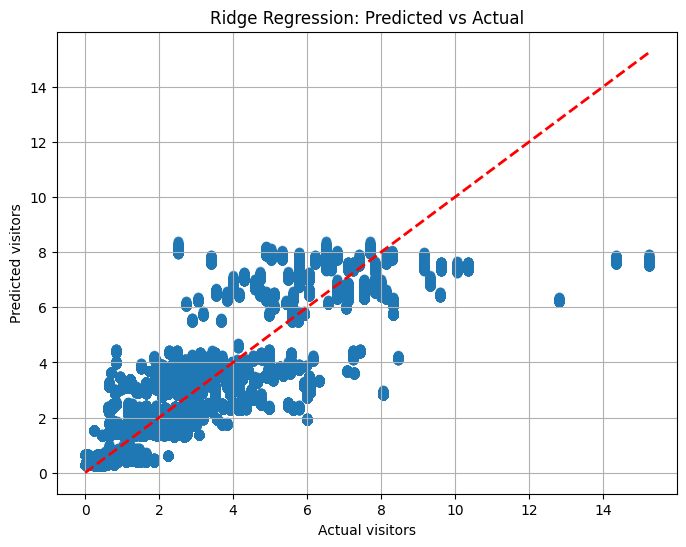

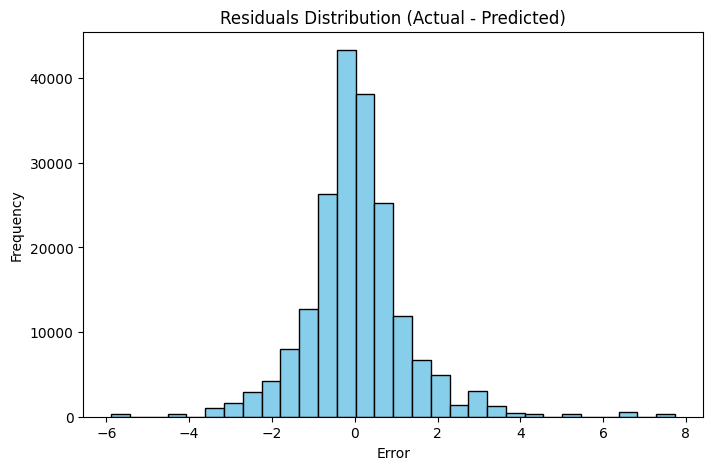

           category  importance  percentage
0  Vessel proximity    1.260686    78.50424
1           Weather    0.345197    21.49576


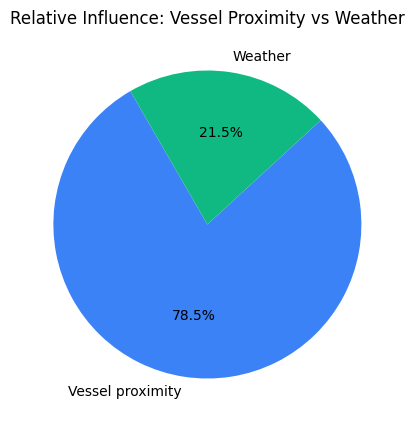

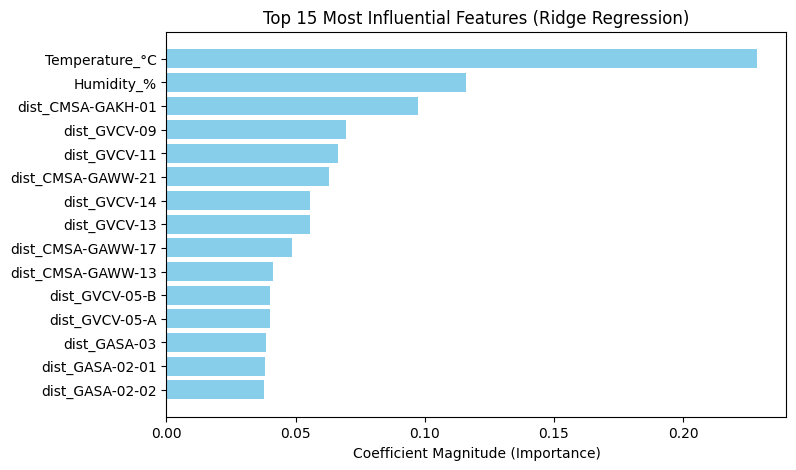

In [40]:
##Visuals

# Compare to your test data (after inverse_transform)
sample_preds = model.predict(X_test[:5])
print("Sample predictions:", sample_preds)
print("Corresponding actuals:", y_test[:5])

# Evaluate performance 
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds)

print("✅ Ridge Model Results")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Optional: Compare average predictions ---
print("\n--- Mean Comparison ---")
print(f"Train target mean: {y_train.mean():.2f}")
print(f"Test  target mean: {y_test.mean():.2f}")
print(f"Pred  mean:        {preds.mean():.2f}")

# --- Visualization ---
plt.figure(figsize=(8,6))
plt.scatter(y_test.flatten(), preds.flatten(), alpha=0.6)
plt.xlabel("Actual visitors")
plt.ylabel("Predicted visitors")
plt.title("Ridge Regression: Predicted vs Actual")
plt.grid(True)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.show()

# --- Residual plot ---
plt.figure(figsize=(8,5))
residuals = y_test.flatten() - preds.flatten()
plt.hist(residuals, bins=30, color='skyblue', edgecolor='k')
plt.title("Residuals Distribution (Actual - Predicted)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

# --- Extract coefficients ---
ridge_model = model.regressor_.named_steps["ridge"]
coefs = ridge_model.coef_

# If multi-output (one model per CMSA column), average them
if coefs.ndim > 1:
    coefs_mean = np.mean(np.abs(coefs), axis=0)
else:
    coefs_mean = np.abs(coefs)

coef_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": coefs_mean
})

# --- Separate into categories ---
coef_df["category"] = np.where(
    coef_df["feature"].str.startswith("dist_"),
    "Vessel proximity",
    "Weather"
)

# --- Aggregate contribution by category ---
cat_summary = (
    coef_df.groupby("category")["importance"]
    .sum()
    .reset_index()
    .sort_values("importance", ascending=False)
)

# --- Normalize to percentage ---
cat_summary["percentage"] = 100 * cat_summary["importance"] / cat_summary["importance"].sum()

print(cat_summary)

# --- Pie chart for overall contribution ---
plt.figure(figsize=(5,5))
plt.pie(
    cat_summary["percentage"],
    labels=cat_summary["category"],
    autopct="%1.1f%%",
    startangle=120,
    colors=["#3b82f6", "#10b981"]
)
plt.title("Relative Influence: Vessel Proximity vs Weather")
plt.show()

# --- Bar chart for top individual features ---
top_features = (
    coef_df
    .sort_values("importance", ascending=False)
    .head(15)
)

plt.figure(figsize=(8,5))
plt.barh(top_features["feature"], top_features["importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Coefficient Magnitude (Importance)")
plt.title("Top 15 Most Influential Features (Ridge Regression)")
plt.show()
